In [5]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read, Stream
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers, kilometer2degrees, gps2dist_azimuth
import pandas as pd
from mudpy import fakequakes

In [6]:
home = '/Users/sydneydybing/SW4/'
project_name = 'strain'
path = home + project_name + '/'

In [7]:
path

'/Users/sydneydybing/SW4/strain/'

In [8]:
# Make or load our custom TauPyModel format velocity model

custom_model = TauPyModel(model = path + 'structure/' + 'mojave_simpletop_forsw4.npz')

# Only need to make the .npz one time, then we can just read it in. Uncomment below to remake

vel_mod_file = path + 'mojave_noheader.mod'
fakequakes.build_TauPyModel(home, project_name, vel_mod_file, background_model = 'PREM')
# custom_model = TauPyModel(model = path + 'structure/' + 'mojave_simpletop_forsw4.npz')
# default_model = TauPyModel(model = 'iasp91') # Non-custom one

Building obspy.taup model for '/Users/sydneydybing/SW4/strain/structure/mojave_noheader.nd' ...
filename = /Users/sydneydybing/SW4/strain/structure/mojave_noheader.nd
Done reading velocity model.
Radius of model . is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  959 P layers,1223 S layers
Done calculating Tau branches.
Done Saving /Users/sydneydybing/SW4/strain/structure/mojave_noheader.npz
Method run is done, but not necessarily successful.


In [9]:
# Event info

# Read in event location file 
event_file = 'M6_catalog_2004-2024.csv'
eventLocs = pd.read_csv(path + event_file)

# Pick your event
event = eventLocs.iloc[11] # Ridgecrest mainshock

hypo_lat = event.latitude
hypo_lon = event.longitude
hypo_depth = event.depth # km

In [10]:
# Stations

sta_file = 'bsm_metadata.csv'
stas = pd.read_csv(path + sta_file)

# Choose subset of stations
rc_stas_sub = ['B072', 'B079', 'B082', 'B087', 'B916', 'B917', 'B918', 'B921'] # subset of stations close to Ridgecrest - 4 super close, 2 west, 2 south
stas_sub = stas.query('BNUM in @rc_stas_sub').reset_index(drop = True)

In [11]:
# Add a column to the stations dataframe with the theoretical P-wave arrival times

dists_km = []
p_arr_times = []

for idx in range(len(stas_sub)):
    
    sta_lat = stas_sub.LAT.values[idx]
    sta_lon = stas_sub.LONG.values[idx]
    dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters
    
    arrivals = custom_model.get_travel_times(source_depth_in_km = hypo_depth, 
                                  distance_in_degree = kilometer2degrees(dist_m/1000), phase_list=['p', 'P'])
    p_arr_time = arrivals[0].time
    
    p_arr_times.append(p_arr_time)
    dists_km.append(dist_m/1000)

stas_sub['hypo_dist_km'] = dists_km
stas_sub['p_arrival'] = p_arr_times

stas_sub.to_csv(path + 'sw4_strain_stations_metadata.csv', index = False)

/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_33791/2726806539.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters


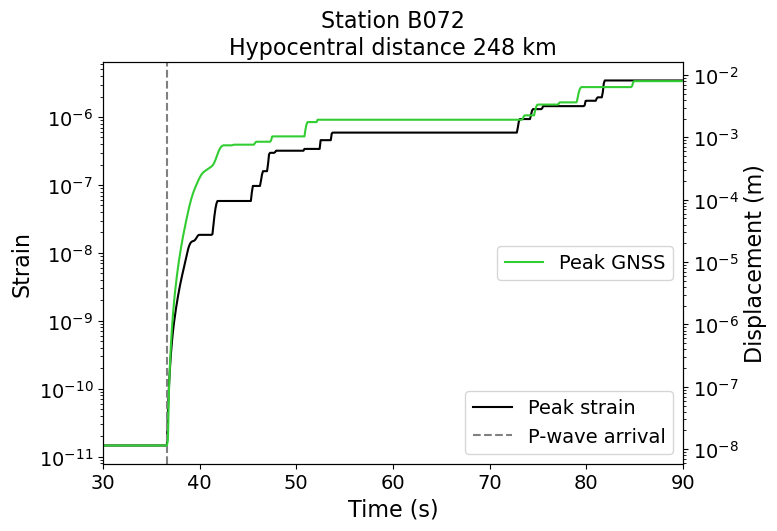

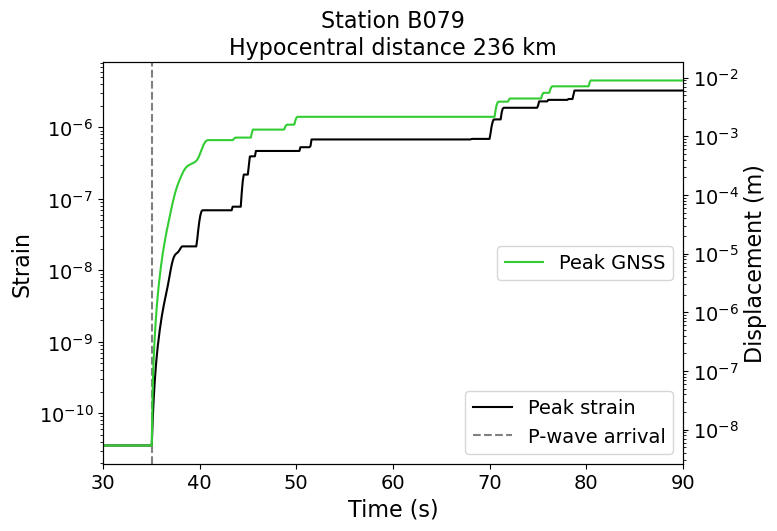

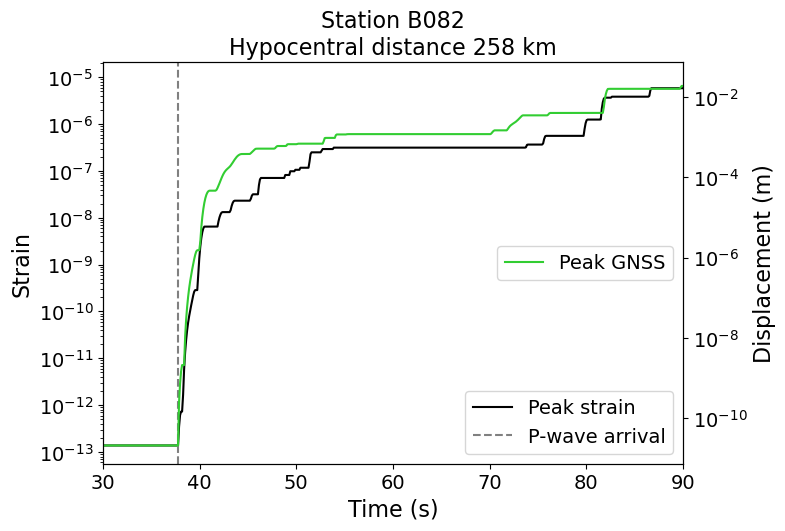

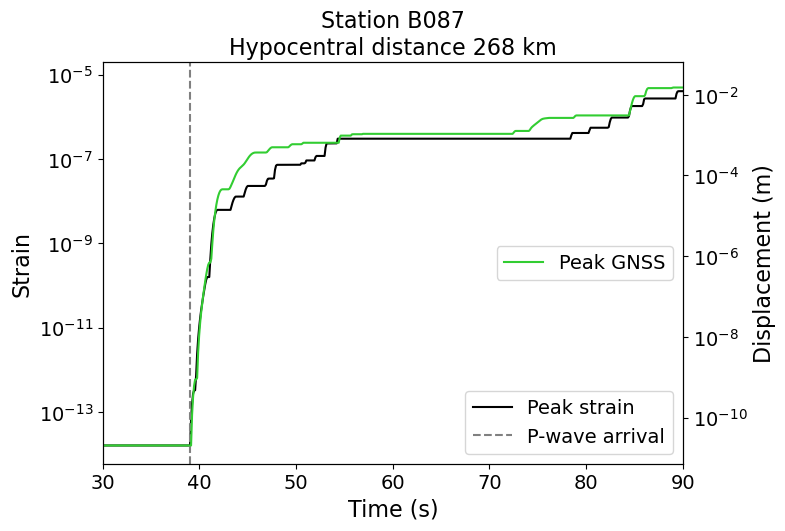

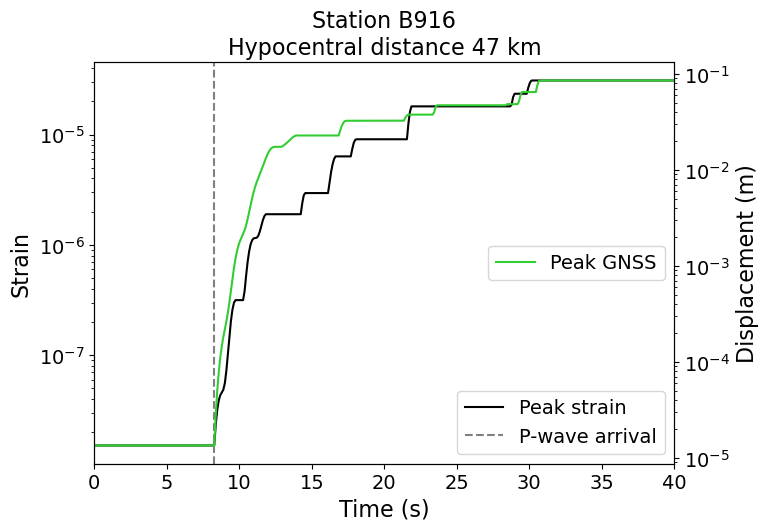

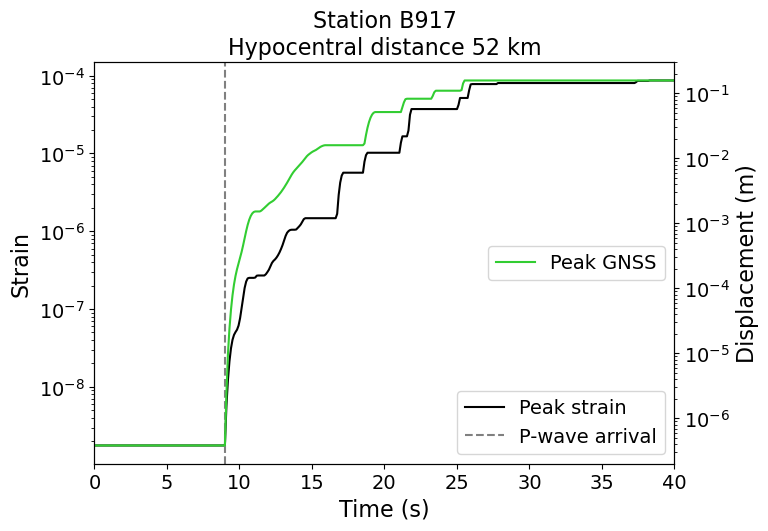

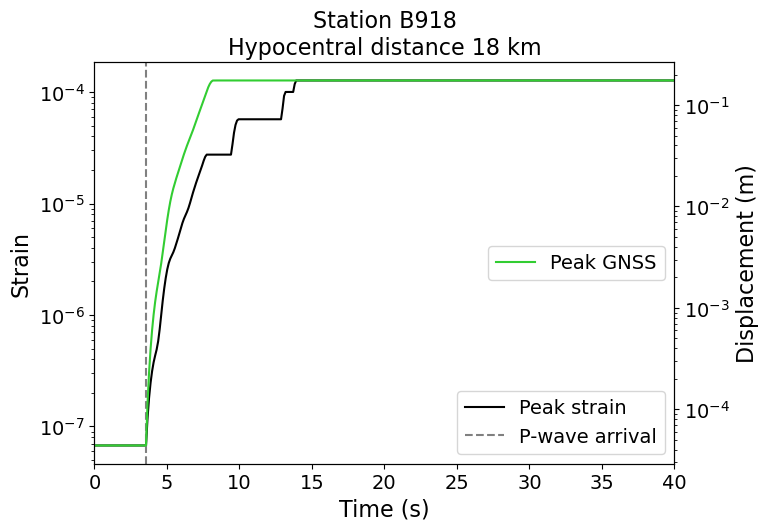

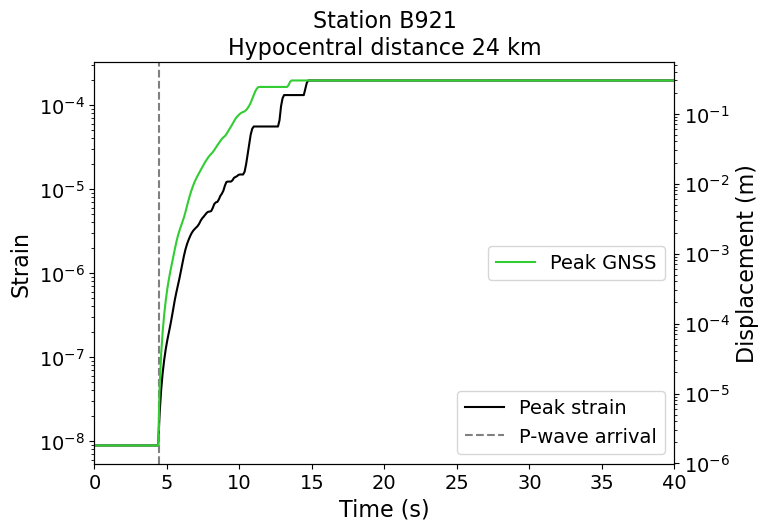

In [14]:
for idx in range(len(stas_sub)):
    
    sta = stas_sub.BNUM.values[idx]
    theo_p_arr = stas_sub.p_arrival.values[idx]
    hypo_dist = stas_sub.hypo_dist_km.values[idx]
    
    sw4_strain = pd.read_csv(path + 'multiseg_oneblock-results/' + sta + 's.txt', sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])
    sw4_gnss = pd.read_csv(path + 'multiseg_oneblock-results/' + sta + 'd.txt', sep = '\s+', skiprows = 13, names = ['time', 'x', 'y', 'z'])
    
    ### Process strain data ###
    
    # Calculate horizontal RMS strain
    time_strain = sw4_strain.time.values
    xx_strain = sw4_strain.xx.values
    xy_strain = sw4_strain.xy.values
    yy_strain = sw4_strain.yy.values
    rms_strain = np.sqrt((xx_strain**2 + xy_strain**2 + yy_strain**2)/3)
    
    # Calculate peak strain
    strain_p_i = np.abs(time_strain - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_strain = rms_strain.copy()
    p_arr_strain = rms_strain[strain_p_i]
    mod_rms_strain[:strain_p_i] = p_arr_strain # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_strain = mod_rms_strain.copy()
    for k in range(0,len(mod_rms_strain)):
        if k == 0:
            strain = mod_rms_strain[0]
            max_strain = strain
        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_rms_strain[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)
        # Put peak strain back into the output stream
        peak_strain[k] = max_strain 
    
    ### Process GNSS data to match the strain processing ###
    
    # Calculate horizontal RMS GNSS  
    time_gnss = sw4_gnss.time.values
    x_gnss = sw4_gnss.x.values
    y_gnss = sw4_gnss.y.values
    rms_gnss = np.sqrt((x_gnss**2 + y_gnss**2)/2)
    
    # Calculate peak GNSS
    gnss_p_i = np.abs(time_gnss - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_gnss = rms_gnss.copy()
    p_arr_gnss = rms_gnss[gnss_p_i]
    mod_rms_gnss[:gnss_p_i] = p_arr_gnss # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_gnss = mod_rms_gnss.copy()
    for k in range(0,len(mod_rms_gnss)):
        if k == 0:
            gnss = mod_rms_gnss[0]
            max_gnss = gnss
        else:
            # Grab progressively longer windows and save the biggest strain
            gnss = mod_rms_gnss[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_gnss = max(gnss)
        # Put peak strain back into the output stream
        peak_gnss[k] = max_gnss 
    
    ### Make plots ###
    
    make_plots(sta, hypo_dist, theo_p_arr, time_strain, rms_strain, peak_strain, time_gnss, rms_gnss, peak_gnss, show_or_save = 'show')
    
    ### Save the new data ###
    
#     both_rms_strain = np.column_stack((time_strain, rms_strain))
#     np.save(path + 'rms_and_peak_sw4_data/strain/rms/' + str(sta) + '.npy', both_rms_strain)
    
#     both_rms_gnss = np.column_stack((time_gnss, rms_gnss))
#     np.save(path + 'rms_and_peak_sw4_data/gnss_at_strain_locs/rms/' + str(sta) + '.npy', both_rms_gnss)
    
#     both_peak_strain = np.column_stack((time_strain, peak_strain))
#     np.save(path + 'rms_and_peak_sw4_data/strain/peak/' + str(sta) + '.npy', both_peak_strain)
    
#     both_peak_gnss = np.column_stack((time_gnss, peak_gnss))
#     np.save(path + 'rms_and_peak_sw4_data/gnss_at_strain_locs/peak/' + str(sta) + '.npy', both_peak_gnss)
    

In [13]:
# Plotting routine for the peak strain and peak GNSS calculated in one of the above cells

def make_plots(sta, hypo_dist, theo_p_arr, time_strain, rms_strain, peak_strain, time_gnss, rms_gnss, peak_gnss, 
               show_or_save = 'show', plot_around_p = False, choose_your_own = False, xlim_low = None, xlim_high = None, plot_peak = True):
  
    # Set xlims
    
    if choose_your_own:
        xlim_low = 0
        xlim_high = 120
    
    if plot_around_p:
        secs_around_p = 10
        if theo_p_arr < secs_around_p: # If the theoretical P arrival is too close to the start of the waveform, start at the beginning
            xlim_low = np.min(time_strain)
        else:
            xlim_low = theo_p_arr - around_p

        if theo_p_arr > np.max(time_strain) - around_p: # If it's too close to the end of the waveform, end at the end
            xlim_high = np.max(time_strain)
        else:
            xlim_high = theo_p_arr + around_p
    
    else: # Pick based on hypocentral distance groups for these specific stations      
        if hypo_dist > 200:
            xlim_low = 30
            xlim_high = 90
        else:
            xlim_low = 0
            xlim_high = 40
    
    if show_or_save == 'show':
        dpi = 100
    else:
        dpi = 400
        
    fig = plt.figure(figsize = (8,5.5), dpi = dpi, facecolor = 'white')
    ax = fig.add_subplot(111)
    ax.set_title('Station ' + str(sta) + '\nHypocentral distance ' + str(round(hypo_dist)) + ' km', fontsize = 16)
    
    
    if plot_peak:
        ax.plot(time_strain, peak_strain, color = 'black', label = 'Peak strain')
        ax.semilogy()
        
    else:
        ax.plot(time_strain, rms_strain, color = 'red', label = 'RMS strain')
        tol = 0.05
        # Finds the index where the strain timeseries equals the low and high x limits you want
        # Want the low y limit to be smaller than the minimum of the timeseries between the low and high xlims
        # And the high y limit to be bigger than the maximum of the timeseries between the low and high xlims
        ax_ylow_i = np.where(np.abs(time_strain - xlim_low) <= tol)[0][0]
        ax_yhigh_i = np.where(np.abs(time_strain - xlim_high) <= tol)[0][0]
        ax_ylim_low = np.min(rms_strain[ax_ylow_i:ax_yhigh_i]) * 0.9
        ax_ylim_high = np.max(rms_strain[ax_ylow_i:ax_yhigh_i]) * 1.1
        ax.set_ylim(ax_ylim_low, ax_ylim_high)
    
    ax2 = ax.twinx()
    
    if plot_peak:
        ax2.plot(time_gnss, peak_gnss, color = 'limegreen', label = 'Peak GNSS')
        ax2.semilogy()
    else:
        ax2.plot(time_gnss, rms_gnss, color = 'blue', label = 'RMS GNSS')
        ax2_ylow_i = np.where(np.abs(time_gnss - xlim_low) <= tol)[0][0]
        ax2_yhigh_i = np.where(np.abs(time_gnss - xlim_high) <= tol)[0][0]
        ax2_ylim_low = np.min(rms_gnss[ax2_ylow_i:ax2_yhigh_i]) * 0.9
        ax2_ylim_high = np.max(rms_gnss[ax2_ylow_i:ax2_yhigh_i]) * 1.1
        ax2.set_ylim(ax2_ylim_low, ax2_ylim_high)
    
    ax.axvline(theo_p_arr, color = 'gray', linestyle = '--', label = 'P-wave arrival')
    ax.set_xlim(xlim_low, xlim_high)
    ax.legend(loc = 'lower right', fontsize = 14)
    ax.set_xlabel('Time (s)', fontsize = 16)
    ax.set_ylabel('Strain', fontsize = 16)
    ax.tick_params(labelsize = 14)
    
    ax2.legend(loc = 'center right', fontsize = 14)
    # ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Displacement (m)', fontsize = 16)
    ax2.tick_params(labelsize = 14)
    
    plt.subplots_adjust(bottom = 0.15, right = 0.85)
    
    if show_or_save == 'show':
        plt.show()
    else:
        print('Saving ' + str(sta) + ' figure')
        plt.savefig(path + 'rms_and_peak_sw4_figs/' + str(sta) + '.png', format = 'PNG')
        plt.close()
